### Install packages and import libraries

In [94]:
!pip install xgboost
!pip install --upgrade imbalanced-learn


[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [95]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost
from xgboost import XGBClassifier
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [96]:
# Set display options to show all columns of a dataframe
pd.set_option('display.max_columns', None)

### Extracting column names from metadata

In [97]:
# csv files do not have headers. Reading column names from metadata
column_names = []
file = open('census_income_metadata.txt')
  
# read the content of the file opened 
content = file.readlines() 
  
# Extracting column names from metadata.
# Column names are in lines 143 to 184 of metadata, except line 167 which has to be ignored.
for i in range(142, 184):
    if i != 166:
        column_names.append(content[i].split(':')[0])
# Last column is the target variable
column_names.append('target')

### Reading csv data

In [98]:
df_train = pd.read_csv('census_income_learn.csv', names = column_names)
df_test = pd.read_csv('census_income_test.csv', names=column_names)
print('Number of rows in train data: {}'.format(df_train.shape[0]))
print('Number of rows in test data: {}'.format(df_test.shape[0]))

Number of rows in train data: 199523
Number of rows in test data: 99762


### Inputs
Using constants/variables for code reusability

In [99]:
# Getting ration of train and test data as we will combine both for some analysis
ratio_train_by_total = df_train.shape[0]/(df_test.shape[0]+df_train.shape[0])
ratio_train_by_total

0.6666655529010809

In [100]:
# This is the threshold number at which we do label encoding instead of one hot encoding
encoding_number = 7

### Combine data and split later before training

In [101]:
df = pd.concat([df_train, df_test], axis=0)

In [102]:
df

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,instance weight,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,target
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99757,14,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1708.85,?,?,?,Not in universe under 1 year old,?,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,95,- 50000.
99758,61,Private,8,36,11th gr

### Data cleaning

In [103]:
df.dtypes

age                                             int64
class of worker                                object
detailed industry recode                        int64
detailed occupation recode                      int64
education                                      object
wage per hour                                   int64
enroll in edu inst last wk                     object
marital stat                                   object
major industry code                            object
major occupation code                          object
race                                           object
hispanic origin                                object
sex                                            object
member of a labor union                        object
reason for unemployment                        object
full or part time employment stat              object
capital gains                                   int64
capital losses                                  int64
dividends from stocks       

In [104]:
# Any None datatype? No
df.isnull().sum()

age                                           0
class of worker                               0
detailed industry recode                      0
detailed occupation recode                    0
education                                     0
wage per hour                                 0
enroll in edu inst last wk                    0
marital stat                                  0
major industry code                           0
major occupation code                         0
race                                          0
hispanic origin                               0
sex                                           0
member of a labor union                       0
reason for unemployment                       0
full or part time employment stat             0
capital gains                                 0
capital losses                                0
dividends from stocks                         0
tax filer stat                                0
region of previous residence            

In [105]:
# Changing object data type to string in the dataframe
obj_features = df.select_dtypes(include='object').columns
df[obj_features] = df[obj_features].fillna('').astype(str)

In [106]:
# Strings in the dataframe have leading white space. Stripping them off of it.
df = df.map(lambda x: x.strip() if isinstance(x, str) else x)

In [107]:
numerical_df = df.select_dtypes(include=['int64', 'float64'])
numerical_df.describe()

,age,detailed industry recode,detailed occupation recode,wage per hour,capital gains,capital losses,dividends from stocks,instance weight,num persons worked for employer,own business or self employed,veterans benefits,weeks worked in year,year
count,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000
mean,34.538998,15.345818,11.314743,55.105027,431.742176,36.849010,195.851259,1740.101125,1.956172,0.176461,1.516498,23.178375,94.499998
std,22.318468,18.053638,14.455980,273.340729,4670.768536,269.789771,1937.847082,994.144299,2.364857,0.555240,0.850395,24.404016,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.870000,0.000000,0.000000,0.000000,0.000000,94.000000
25%,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1060.490000,0.000000,0.000000,2.000000,0.000000,94.000000
50%,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1617.110000,1.000000,0.000000,2.000000,8.000000,94.000000
75%,50.000000,33.000000,26.000000,0.000000,0.000000,0.000000,0.000000,2188.110000,4.000000,0.000000,2.000000,52.000000,95.000000
max,90.000000,51.000000,46.000000,9999.000000,99999.000000,4608.000000,99999.000000,18656.300000,6.000000,2.000000,2.000000,52.000000,95.000000


Wage per hour, capital gains and capital losses have 9999, 99999, 99999 respectively. Taking the mean of the rest of the data and replacing these sketchy datapoints.

In [108]:
print(f"{df[df['capital gains'] == 99999].shape[0]} outlier in the capital gains column")
print(f"{df[df['dividends from stocks'] == 99999].shape[0]} outlier in the dividends from stocks column")
print(f"{df[df['wage per hour'] == 9999].shape[0]} outlier in the wage per hour column")

578 outlier in the capital gains column
31 outlier in the dividends from stocks column
1 outlier in the wage per hour column


In [109]:
df['capital gains'] = df['capital gains'].replace(99999, np.mean(df['capital gains'].values))
df['dividends from stocks'] = df['dividends from stocks'].replace(99999, np.mean(df['dividends from stocks'].values))
df['wage per hour'] = df['wage per hour'].replace(9999, np.mean(df['wage per hour'].values))

In [110]:
# Save this dataframe to use later while plotting graphs
df_original = df

### Data Treatment
Paying special attention to some columns: Education, year, target, and columns with countries

In [111]:
# Drop column year as the data is seen as a whole and doesn't depend on which year the census was taken
df.drop('year', axis=1, inplace=True)

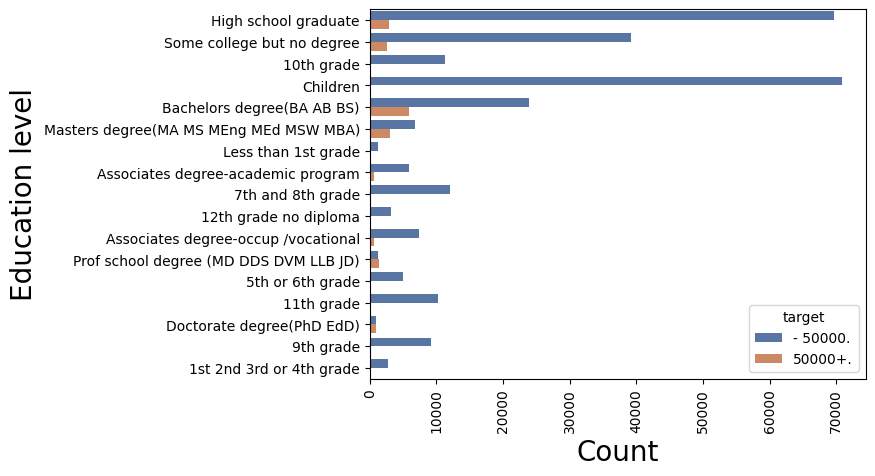

In [112]:
sns.countplot(data= df, y='education', hue='target')
plt.ylabel('Education level',fontsize=20)
plt.xticks(rotation=90)
plt.xlabel('Count',fontsize=20)
plt.show()

In [113]:
# Label encoding in Education column with a notion of ordering: Children get 0, Less than 1st grade gets 1 and so on till the highest education gets the maximum number 16. 
df['education'].unique()
mapping = {'High school graduate' : 9,
           'Some college but no degree': 10,
           '10th grade': 6,
           'Children': 0,
           'Bachelors degree(BA AB BS)': 13,
           'Masters degree(MA MS MEng MEd MSW MBA)': 14,
           'Less than 1st grade': 1,
           'Associates degree-academic program': 12,
           '7th and 8th grade': 4,
           '12th grade no diploma': 8,
           'Associates degree-occup /vocational': 11,
           'Prof school degree (MD DDS DVM LLB JD)': 15,
           '5th or 6th grade': 3,
           '11th grade': 7,
           'Doctorate degree(PhD EdD)': 16,
           '9th grade': 5,
           '1st 2nd 3rd or 4th grade': 2
    }
df['education'] = df['education'].map(mapping)

In [114]:
# Changing the income target to 0 (-50000) and 1 (+50000)
df['target'].unique()
df['target'] = df['target'].map(lambda x: 0 if (x == '- 50000.') else 1)

Columns with countries need to be treated separatedly. We collect all country names into one set and give it a label encoder. We use the same encoder on the three columns with countries. This keeps the integrety of the data rather than using different label encoders on the three columns.

In [115]:
# All countries go into a set
unique_countries = set(df[['country of birth father', 'country of birth mother', 'country of birth self']].values.flatten())
# Create a LabelEncoder instance
country_label_encoder = LabelEncoder()
# Fit the LabelEncoder on the set of countries
country_label_encoder.fit(list(unique_countries))
# Transform the columns with countries using the fitted LabelEncoder
df['country of birth father'] = country_label_encoder.transform(df['country of birth father'])
df['country of birth mother'] = country_label_encoder.transform(df['country of birth mother'])
df['country of birth self'] = country_label_encoder.transform(df['country of birth self'])

### Feature engineering
Introducing a new feature 'net income' 

In [116]:
#df['net income'] = df['wage per hour']*df['weeks worked in year']*8*5 + df['capital gains'] - df['capital losses'] + df['dividends from stocks']
df['net income'] = df['capital gains'] - df['capital losses'] + df['dividends from stocks']
df['net income'].describe()

count    299285.000000
mean        388.115583
std        2436.307575
min       -4608.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      115146.000000
Name: net income, dtype: float64

In [117]:
df

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,race,hispanic origin,sex,member of a labor union,reason for unemployment,full or part time employment stat,capital gains,capital losses,dividends from stocks,tax filer stat,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,instance weight,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,target,net income
0,73,Not in universe,0,0,9,0.0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0.0,0,0.0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,1700.09,?,?,?,Not in universe under 1 year old,?,0,Not in universe,40,40,40,Native- Born in the United States,0,Not in universe,2,0,0,0.0
1,58,Self-employed-not incorporated,4,34,10,0.0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0.0,0,0.0,Head of household,South,Arkansas,Householder,Householder,1053.55,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,40,40,40,Native- Born in the United States,0,Not in universe,2,52,0,0.0
2,18,Not in universe,0,0,6,0.0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0.0,0,0.0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,991.95,?,?,?,Not in universe under 1 year old,?,0,Not in universe,41,41,41,Foreign born- Not a citizen of U S,0,Not in universe,2,0,0,0.0
3,9,Not in universe,0,0,0,0.0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0.0,0,0.0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1758.14,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,40,40,40,Native- Born in the United States,0,Not in universe,0,0,0,0.0
4,10,Not in universe,0,0,0,0.0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0.0,0,0.0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1069.16,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,40,40,40,Native- Born in the United States,0,Not in universe,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99757,14,Not in universe,0,0,0,0.0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0.0,0,0.0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,1708.85,?,?,?,Not in universe under 1 year old,?,0,Both parents present,40,40,40,Native- Born in the United States,0,Not in universe,0,0,0,0.0
99758,61,Private,8,36,7,0.0,Not in universe,Separated,Manufacturing-durable goods,Machine operators assmblrs & inspctrs,Black,All other,Male,No,Not in universe,Full-time schedules,0.0,0,0.0,Single,Not in universe,Not in universe,Nonfamily householder,Householder,2511.11,?,?,?

### Feature selection - filtering
Using the correlation matrix for feature selection. First deciding between choice of encoding between one hot encoding and label encoding

In [118]:
# Obtaining list of columns with str datatype
str_features = df.select_dtypes(include='object').columns

In [119]:
count = 0
for column_x in str_features:
    if df[column_x].nunique() < encoding_number:
        # One hot encoding
        dummies = pd.get_dummies(df[column_x], dtype='int',drop_first=True, prefix=column_x)
        df = pd.concat([df, dummies], axis=1)
        df.drop(columns=[column_x], inplace=True)
        count += 1
    else:
        # Label encoding
        # Initialize LabelEncoder
        label_encoder = LabelEncoder()
        # Fit and Transform the column
        df[column_x] = label_encoder.fit_transform(df[column_x])

#### Scaling data

In [120]:
df.describe()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,marital stat,major industry code,major occupation code,hispanic origin,full or part time employment stat,capital gains,capital losses,dividends from stocks,state of previous residence,detailed household and family stat,detailed household summary in household,instance weight,migration code-change in msa,migration code-change in reg,migration code-move within reg,num persons worked for employer,country of birth father,country of birth mother,country of birth self,own business or self employed,veterans benefits,weeks worked in year,target,net income,enroll in edu inst last wk_High school,enroll in edu inst last wk_Not in universe,race_Asian or Pacific Islander,race_Black,race_Other,race_White,sex_Male,member of a labor union_Not in universe,member of a labor union_Yes,reason for unemployment_Job loser - on layoff,reason for unemployment_New entrant,reason for unemployment_Not in universe,reason for unemployment_Other job loser,reason for unemployment_Re-entrant,tax filer stat_Joint both 65+,tax filer stat_Joint both under 65,tax filer stat_Joint one under 65 & one 65+,tax filer stat_Nonfiler,tax filer stat_Single,region of previous residence_Midwest,region of previous residence_Northeast,region of previous residence_Not in universe,region of previous residence_South,region of previous residence_West,live in this house 1 year ago_Not in universe under 1 year old,live in this house 1 year ago_Yes,migration prev res in sunbelt_No,migration prev res in sunbelt_Not in universe,migration prev res in sunbelt_Yes,family members under 18_Father only present,family members under 18_Mother only present,family members under 18_Neither parent present,family members under 18_Not in universe,citizenship_Foreign born- U S citizen by naturalization,citizenship_Native- Born abroad of American Parent(s),citizenship_Native- Born in Puerto Rico or U S Outlying,citizenship_Native- Born in the United States,fill inc questionnaire for veteran's admin_Not in universe,fill inc questionnaire for veteran's admin_Yes
count,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.00000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000,299285.000000
mean,34.538998,3.487859,15.345818,11.314743,7.068056,55.071801,3.005015,13.004895,6.307276,0.747772,0.689380,239.450965,36.849010,185.513629,34.954064,20.054891,3.964054,1740.101125,3.258944,3.014685,3.491896,1.956172,35.472102,35.656832,37.494094,0.176461,1.516498,23.178375,0.062041,388.115583,0.034743,0.936789,0.02923,0.102040,0.018578,0.838592,0.479509,0.904629,0.014952,0.004958,0.002148,0.969260,0.010512,0.010168,0.041853,0.337321,0.019527,0.375769,0.188165,0.017619,0.013455,0.921590,0.024438,0.020449,0.507479,0.414110,0.049445,0.421591,0.028966,0.009446,0.063582,0.008223,0.723812,0.029627,0.009045,0.007541,0.886603,0.989939,0.001971
std,22.318468,1.104994,18.053638,14.455980,4.716297,272.735698,1.410120,4.787233,3.102457,2.059241,1.198677,1622.692253,269.789771,1650.276634,5.629069,11.422959,2.069263,994.144299,3.395628,3.102050,3.593640,2.364857,10.607000,10.381285,8.199608,0.555240,0.850395,

In [121]:
# Splitting data into test, train
# Separate target variable as y
# Scaling train and test data separately

df_X = df.drop('target', axis=1)
y = df['target']


In [122]:
# Split the data into train and test
# Calculate the number of training samples
train_size = int(len(df_X) * ratio_train_by_total)

x_train = df_X[:train_size]
y_train = y[:train_size]

x_test = df_X[train_size:]
y_test = y[train_size:]

In [123]:
# Scaling data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

# Retaining scaled data as a dataframe
x_train = pd.DataFrame(x_train_scaled, columns=df_X.columns)
x_test = pd.DataFrame(x_test_scaled, columns=df_X.columns)

T0 avoid repetition of information, calculating the correlation matrix to drop columns that are highly positively or negatively correlated. 

In [124]:
# Calculate the correlation matrix
correlation_matrix = x_train.corr()

# Absolute value of the correlation matrix
abs_corr_matrix = correlation_matrix.abs()
# Mask for the upper triangle
upper = abs_corr_matrix.where(np.triu(np.ones(abs_corr_matrix.shape), k=1).astype(bool))
# Identify columns to drop
threshold = 0.8
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print("Dropped columns:")
print(to_drop)

Dropped columns:
['detailed household summary in household', 'migration code-change in reg', 'migration code-move within reg', 'veterans benefits', 'live in this house 1 year ago_Not in universe under 1 year old', 'live in this house 1 year ago_Yes', 'migration prev res in sunbelt_Not in universe', 'family members under 18_Not in universe', 'citizenship_Native- Born in the United States']


In [125]:
# Drop these columns from the test and train data
x_train = x_train.drop(columns=to_drop)
x_test = x_test.drop(columns=to_drop)

#### Sampling data to fix imbalance

The data is highly imbalanced. 93.79% are low income earners and the rest are high income earners. Models cannot learn well from imbalanced data. This is rectified by oversampling the minority data, ie high income earners.

In [126]:
y_train.value_counts()

target
0    187141
1     12382
Name: count, dtype: int64

In [127]:
187141/(187141+12382)

0.9379419916500854

In [128]:
# Random oversampling to make the majority and minority class even

rd_over_sample = RandomOverSampler()
X_sampled, y_sampled = rd_over_sample.fit_resample(x_train,y_train)

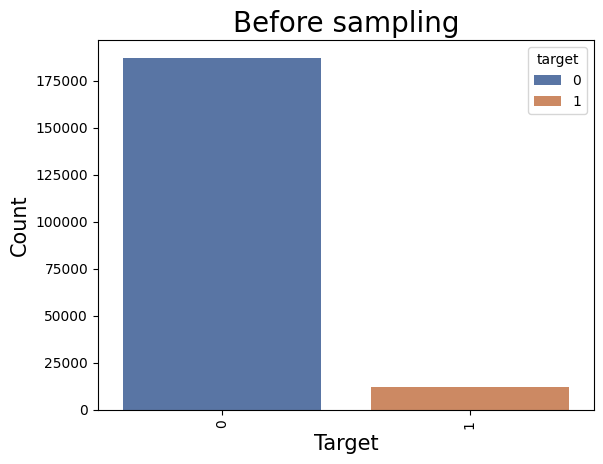

In [129]:
sns.countplot(data= pd.DataFrame(y_train), x='target', hue='target')
plt.xlabel('Target',fontsize=15)
plt.xticks(rotation=90)
plt.ylabel('Count',fontsize=15)
plt.title("Before sampling",fontsize=20)
plt.show()

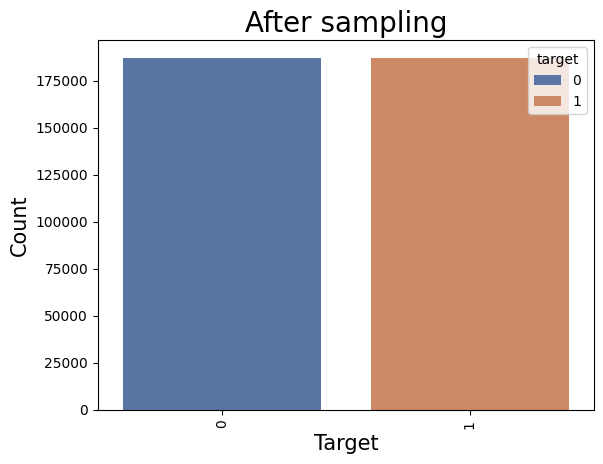

In [130]:
sns.countplot(data= pd.DataFrame(y_sampled, columns=['target']), x='target', hue='target')
plt.xlabel('Target',fontsize=15)
plt.xticks(rotation=90)
plt.ylabel('Count',fontsize=15)
plt.title("After sampling",fontsize=20)
plt.show()

In [131]:
x_train = X_sampled
y_train = pd.DataFrame(y_sampled, columns=['target'])

# Models

Various models for classification are implemented and see which ones perform well.

In [ ]:
# Saving model scores in list for final evaluation
accuracy_test = []
accuracy_train = []
F1score_test = []
F1score_train = []


In [ ]:
# Defining a function to print scores and save them in lists.
def scoring():
    """ A function to print scores and save them in lists. """
    
    print("-----Test Data Accuracy----")
    a_s = round(accuracy_score(y_test.to_numpy(), y_pred), 4)
    print('Accuracy score:', a_s)
    f_1 = round(f1_score(y_test.to_numpy(), y_pred), 4)
    print('F1 score:', f_1)
    accuracy_test.append(a_s)
    F1score_test.append(f_1)

    print("\n-----Train Data Accuracy----")
    a_s = round(accuracy_score(y_train.to_numpy(), y_pred_train), 4)
    print('Accuracy score:', a_s)
    f_1 = round(f1_score(y_train.to_numpy(), y_pred_train), 4)
    print('F1 score:', f_1)
    accuracy_train.append(a_s)
    F1score_train.append(f_1)
    

### Logistic Regression

In [ ]:
lr = LogisticRegression(random_state=0)

# Training Model
lr.fit(x_train,y_train)

# Model Summary
y_pred = lr.predict(x_test)
y_pred_train = lr.predict(x_train)

scoring()

/Users/arpitha/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Decision Tree Classifier

In [ ]:
dt = DecisionTreeClassifier(max_depth=10,random_state=0)

# Training Model
dt.fit(x_train,y_train)
 
# Model Summary
y_pred = dt.predict(x_test)
y_pred_train = dt.predict(x_train)

scoring()

-----Test Data Accuracy----
Accuracy score: 0.8476
F1 score: 0.4178

-----Train Data Accuracy----
Accuracy score: 0.8857
F1 score: 0.8896


### Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(random_state=0, max_depth=30)

# Training Model
rfc.fit(x_train,y_train)

# Model summary
y_pred = rfc.predict(x_test)
y_pred_train = rfc.predict(x_train)

scoring()

/Users/arpitha/.local/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


-----Test Data Accuracy----
Accuracy score: 0.9476
F1 score: 0.5863

-----Train Data Accuracy----
Accuracy score: 0.9929
F1 score: 0.9929


The top ten features that are most important are extracted and used for further analysis.

In [ ]:
# Extract feature importances
importances = rfc.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': importances
})

# Sort features by importance
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Display the top 10 features
print("Top 10 Features for Income Classification:")
print(top_features)

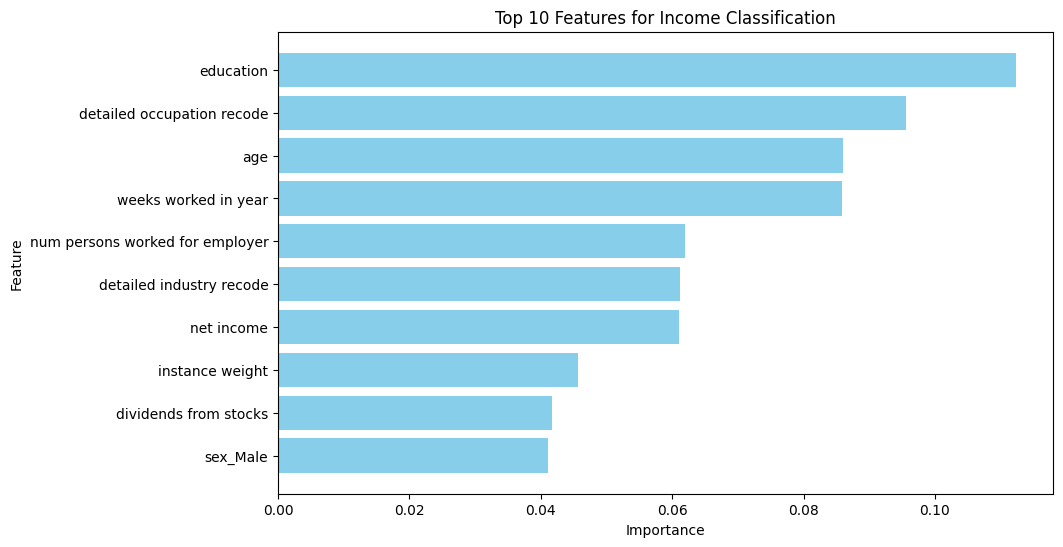

In [ ]:
# Visualize feature importance
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features for Income Classification')
plt.gca().invert_yaxis()
plt.show()

### XGBoost Classifier

In [ ]:

xgb = XGBClassifier(random_state=0)

# Training Model
xgb.fit(x_train, y_train)

# Mode summary
y_pred = xgb.predict(x_test)
y_pred_train = xgb.predict(x_train)

scoring()

-----Test Data Accuracy----
Accuracy score: 0.921
F1 score: 0.5075

-----Train Data Accuracy----
Accuracy score: 0.9203
F1 score: 0.9222


### Voting Classifier

In [ ]:
voting_model = VotingClassifier(estimators=[
    ('rf', DecisionTreeClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42)),
    ('lr', XGBClassifier(random_state=42))
], voting='soft')
voting_model.fit(x_train, y_train)

# Mode summary
y_pred = voting_model.predict(x_test)
y_pred_train = voting_model.predict(x_train)

scoring()


/Users/arpitha/.local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arpitha/.local/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


-----Test Data Accuracy----
Accuracy score: 0.9304
F1 score: 0.5431

-----Train Data Accuracy----
Accuracy score: 0.9678
F1 score: 0.9683


### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf_Dec = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5, random_state=0)
ada_clf_Dec.fit(x_train, y_train)
y_pred_Dec = ada_clf_Dec.predict(x_test)

# Mode summary
y_pred = ada_clf_Dec.predict(x_test)
y_pred_train = ada_clf_Dec.predict(x_train)

scoring()

/Users/arpitha/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/arpitha/.local/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


-----Test Data Accuracy----
Accuracy score: 0.8536
F1 score: 0.4322

-----Train Data Accuracy----
Accuracy score: 0.8742
F1 score: 0.877


### Neuralnet

The following section is commented out as the model is already trained and the loaded model will be used.

In [144]:
# Define the neural network model
# model = Sequential()
# model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

# # Compile the model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [145]:
# Train the model
#history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), verbose=1)


In [146]:
# Save the entire model
#model.save('income_prediction_model.keras')


In [147]:
loaded_model = tf.keras.models.load_model('income_prediction_model.keras')

/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [148]:
# Evaluate the model on the test set
# y_pred = (model.predict(x_test) > 0.5).astype("int32")
# y_pred_train = (model.predict(x_train) > 0.5).astype("int32")

y_pred = (loaded_model.predict(x_test) > 0.5).astype("int32")
y_pred_train = (loaded_model.predict(x_train) > 0.5).astype("int32")




3118/3118 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
11697/11697 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step


In [149]:
scoring()

-----Test Data Accuracy----
Accuracy score: 0.8569
F1 score: 0.4336

-----Train Data Accuracy----
Accuracy score: 0.8861
F1 score: 0.8894


### Visualizations

Based on the top ten features, the following characteristics are examined and their relationship with income.

In [150]:
sns.set_palette('deep')

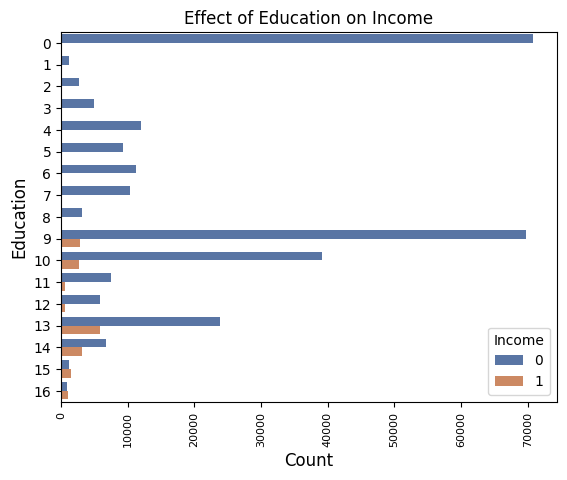

In [151]:
column_x = 'education'
sns.countplot(data= df_original, y=column_x, hue='target')
plt.ylabel(column_x.title(),fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Count',fontsize=12)
plt.title('Effect of Education on Income')
legend = plt.gca().get_legend()
legend.set_title('Income')
plt.show()

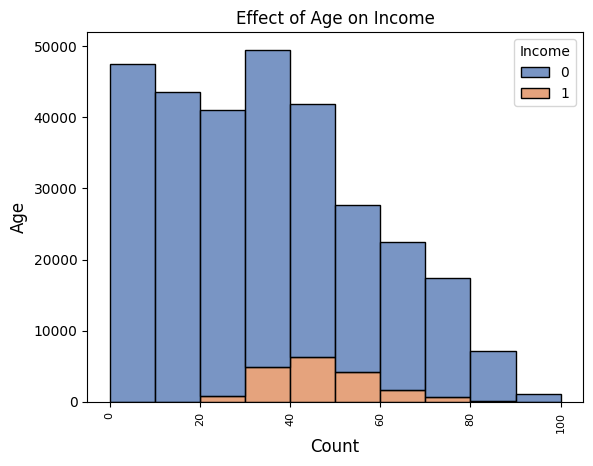

In [152]:
column_x = 'age'
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
#labels = ['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100']
sns.histplot(data= df_original, x=column_x, hue='target',multiple='stack',bins=bins)
plt.ylabel(column_x.title(),fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Count',fontsize=12)
plt.title('Effect of Age on Income')
# Get the current legend
legend = plt.gca().get_legend()
legend.set_title('Income')
plt.show()

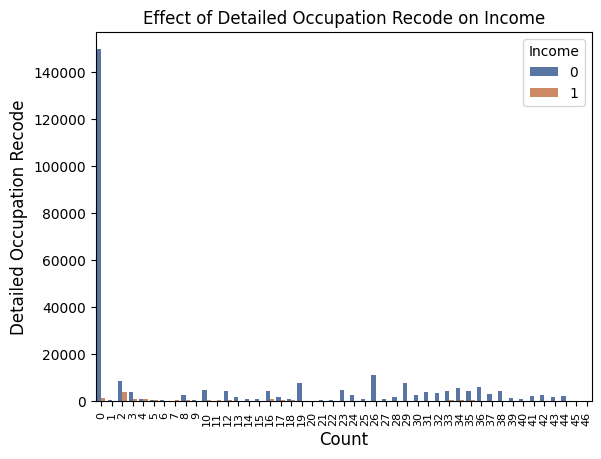

In [153]:

column_x = 'detailed occupation recode'
sns.countplot(data= df_original, x=column_x, hue='target')
plt.ylabel(column_x.title(),fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Count',fontsize=12)
plt.title('Effect of Detailed Occupation Recode on Income')
legend = plt.gca().get_legend()
legend.set_title('Income')
plt.show()

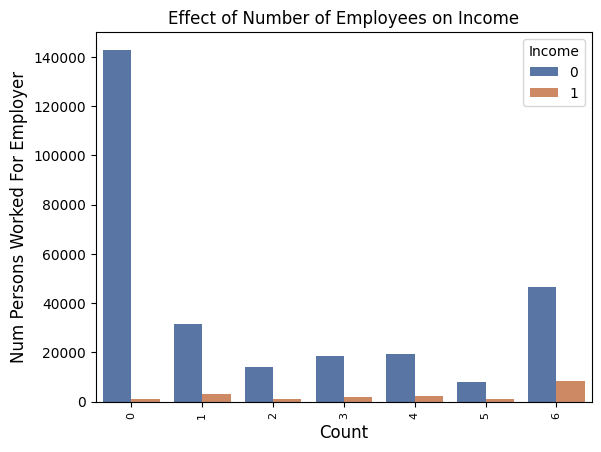

In [154]:
column_x = 'num persons worked for employer'
sns.countplot(data= df_original, x=column_x, hue='target')
plt.ylabel(column_x.title(),fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Count',fontsize=12)
plt.title('Effect of Number of Employees on Income')
legend = plt.gca().get_legend()
legend.set_title('Income')
plt.show()

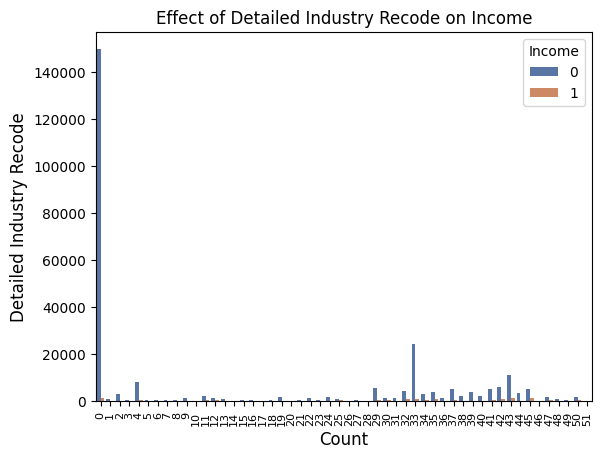

In [155]:
column_x = 'detailed industry recode'
sns.countplot(data= df_original, x=column_x, hue='target')
plt.ylabel(column_x.title(),fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Count',fontsize=12)
plt.title('Effect of Detailed Industry Recode on Income')
legend = plt.gca().get_legend()
legend.set_title('Income')
plt.show()

Index(['Householder', 'Child <18 never marr not in subfamily',
       'Spouse of householder', 'Nonfamily householder',
       'Child 18+ never marr Not in a subfamily', 'Secondary individual',
       'Other Rel 18+ ever marr not in subfamily',
       'Grandchild <18 never marr child of subfamily RP',
       'Other Rel 18+ never marr not in subfamily',
       'Grandchild <18 never marr not in subfamily'],
      dtype='object', name='detailed household and family stat')


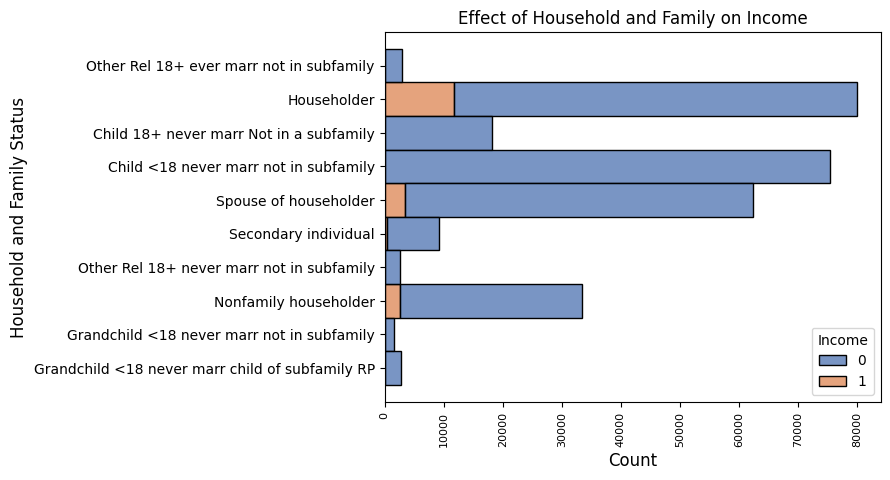

In [ ]:
# There are too many categories in 'detailed household and family stat' column. 10 categories that have the most impact are selected.
category_counts = df_original['detailed household and family stat'].value_counts()

# Select the top 10 most frequent categories
top_10_categories = category_counts.head(10).index

filtered_df = df_original[df_original['detailed household and family stat'].isin(top_10_categories)]

sns.histplot(data= filtered_df, y='detailed household and family stat', hue='target',multiple='stack')
plt.ylabel('Household and Family Status',fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Count',fontsize=12)
plt.title('Effect of Household and Family on Income')
# Get the current legend
legend = plt.gca().get_legend()
legend.set_title('Income')
plt.show()

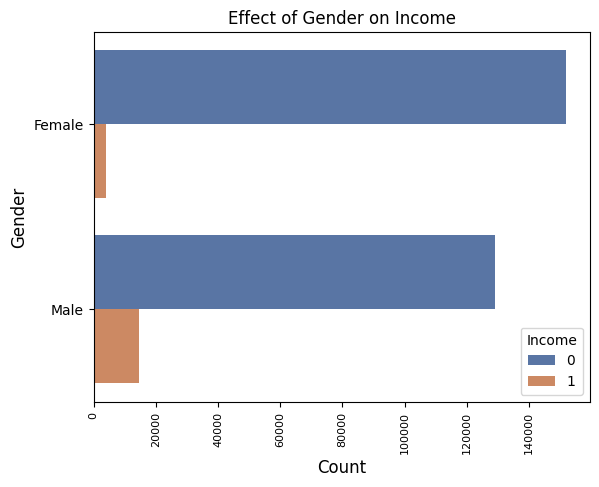

In [157]:
column_x = 'sex'
sns.countplot(data= df_original, y=column_x, hue='target')
plt.ylabel('Gender',fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Count',fontsize=12)
plt.title('Effect of Gender on Income')
legend = plt.gca().get_legend()
legend.set_title('Income')
plt.show()

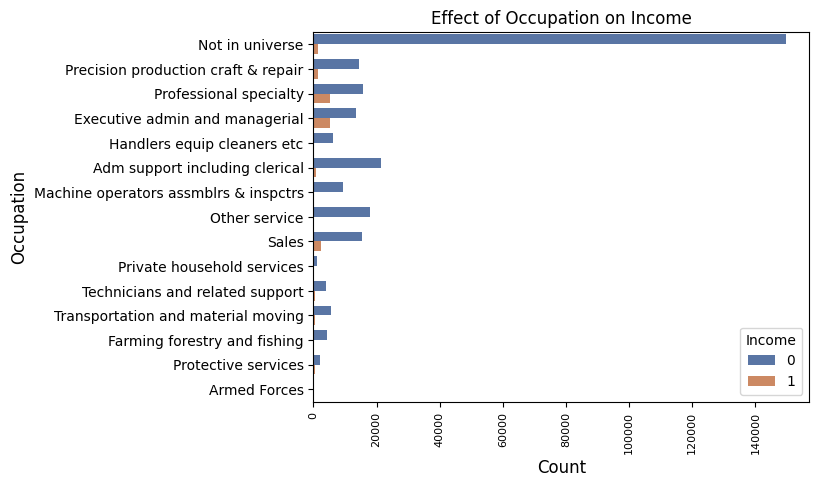

In [158]:
column_x = 'major occupation code'
sns.countplot(data= df_original, y=column_x, hue='target')
plt.ylabel('Occupation',fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Count',fontsize=12)
plt.title('Effect of Occupation on Income')
legend = plt.gca().get_legend()
legend.set_title('Income')
plt.show()

#### Models and scores

Scores of modles are tabulated and graphed.

In [159]:
dictionary_models = {'Model':['Logistic Regression','Decision Tree Classifier','Random Forest Classifier','XGBoost Classifier','Voting Classifier','Ada Boost Classifier', 'NeuralNet'],
                      'Accuracy score (test)': accuracy_test,
                      'Accuracy score (train)': accuracy_train,
                      'F1-Score (test)': F1score_test,
                      'F1-Score (train)': F1score_train
                      }

In [160]:
models = pd.DataFrame(dictionary_models)
models

,Model,Accuracy score (test),Accuracy score (train),F1-Score (test),F1-Score (train)
0,Logistic Regression,0.8395,0.8616,0.4072,0.8653
1,Decision Tree Classifier,0.8476,0.8857,0.4178,0.8896
2,Random Forest Classifier,0.9476,0.9929,0.5863,0.9929
3,XGBoost Classifier,0.9210,0.9203,0.5075,0.9222
4,Voting Classifier,0.9304,0.9678,0.5431,0.9683
5,Ada Boost Classifier,0.8536,0.8742,0.4322,0.8770
6,NeuralNet,0.8569,0.8861,0.4336,0.8894


In [161]:
df_melted = models.melt(id_vars='Model', value_vars=['Accuracy score (test)', 'Accuracy score (train)'], 
                    var_name='Metric', value_name='Score')

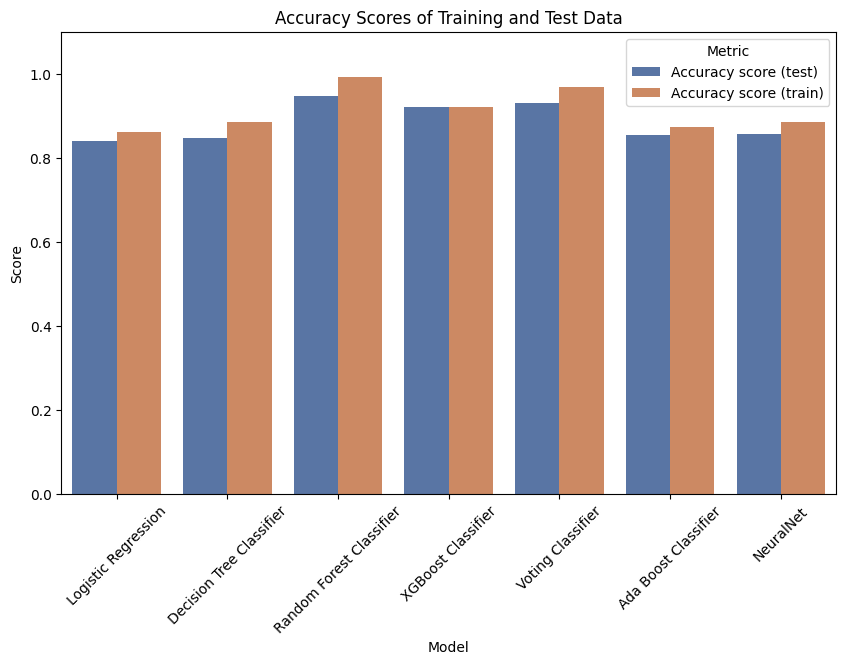

In [162]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=df_melted)
plt.title('Accuracy Scores of Training and Test Data')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.show()


In [163]:
df_melted = models.melt(id_vars='Model', value_vars=['F1-Score (test)', 'F1-Score (train)'], 
                    var_name='Metric', value_name='Score')

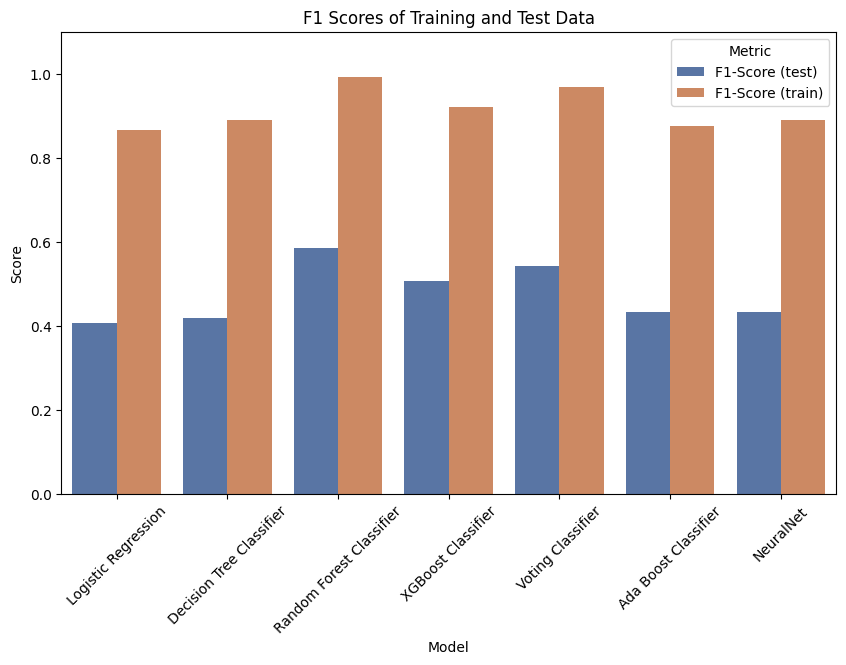

In [164]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=df_melted)
plt.title('F1 Scores of Training and Test Data')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0, 1.1)
plt.legend(title='Metric')
plt.show()